In [1]:
import sys
import torch
from collections import Counter
sys.path.append("../src/models")
import train

In [2]:
# Load data
train_loader, val_loader = train.get_dataloaders("../data/processed/normalized_dataset_subset100.pt", 
                                                 batch_size=32)

# Create model
num_classes = len(Counter(val_loader.dataset.tensors[1].tolist())) 
model = train.SimpleCNN(num_classes=num_classes)

# Create a ResNet18 model (pretrained or not)
resnet_model = train.get_resnet18(num_classes=num_classes, pretrained=True)  # or pretrained=False


device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

# Train both models in a loop
results = {}
for name, m in zip(['SimpleCNN', 'ResNet18'], [model, resnet_model]):
    print(f"Training {name}...")
    train_losses, val_losses, val_accuracies = train.train_model(
        m, train_loader, val_loader, epochs=3, lr=0.0001, device=device
    )
    results[name] = {
        'train_loss': train_losses,
        'val_loss': val_losses,
        'val_acc': val_accuracies
    }

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using mps device
Training SimpleCNN...
Epoch 1/3, Loss: 2.3274, Val Loss: 2.1909, Val Acc: 0.1594
Epoch 2/3, Loss: 2.1148, Val Loss: 2.0525, Val Acc: 0.2500
Epoch 3/3, Loss: 1.9563, Val Loss: 1.9580, Val Acc: 0.3333
Training ResNet18...
Epoch 1/3, Loss: 1.6442, Val Loss: 1.1048, Val Acc: 0.6268
Epoch 2/3, Loss: 0.6787, Val Loss: 1.1154, Val Acc: 0.6051
Epoch 3/3, Loss: 0.3272, Val Loss: 0.9305, Val Acc: 0.6993


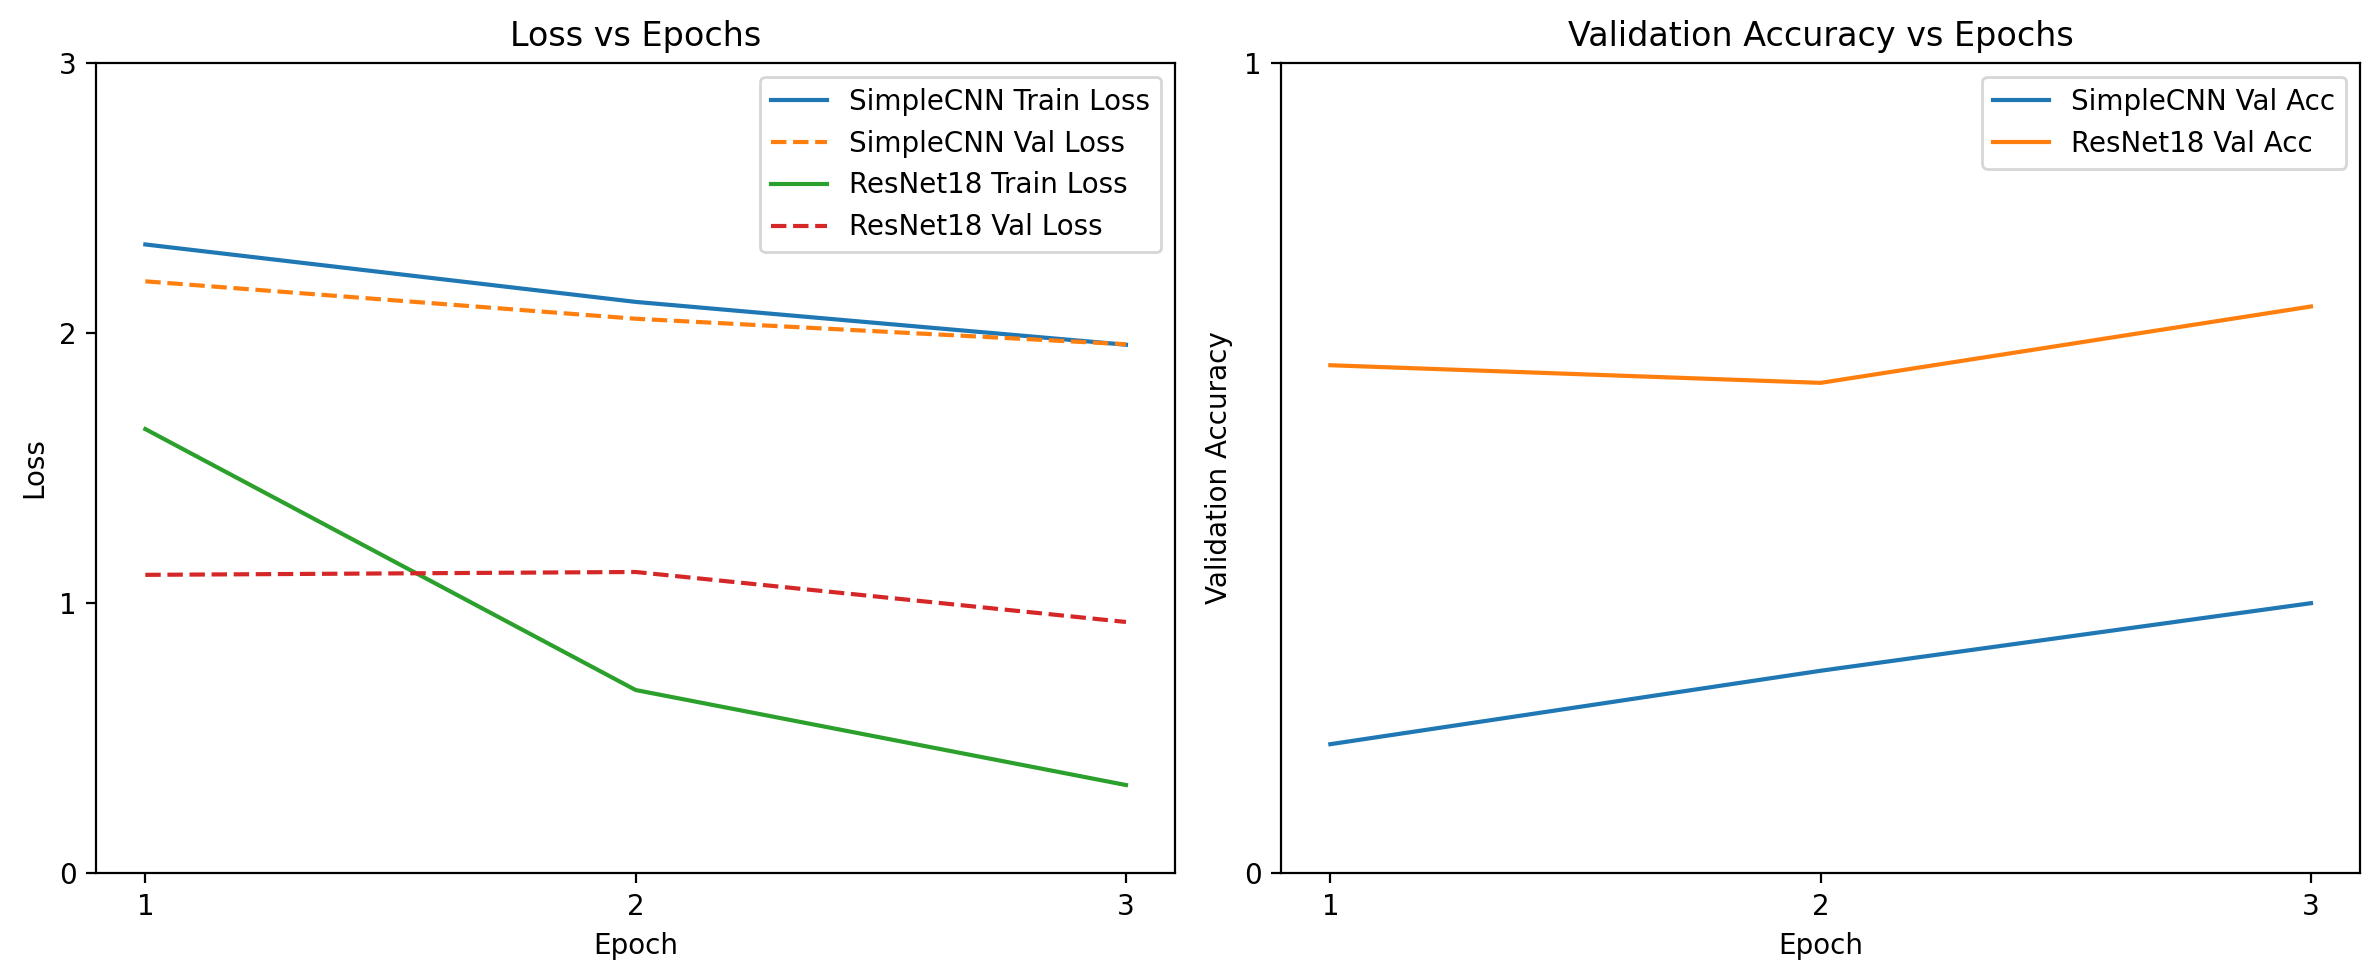

In [7]:
sys.path.append("../src")
import matplotlib.pyplot as plt
from visualization.plot_performance import plot_results

epochs = range(1, len(results['SimpleCNN']['train_loss']) + 1)
plot_results(results=results, epochs=epochs)